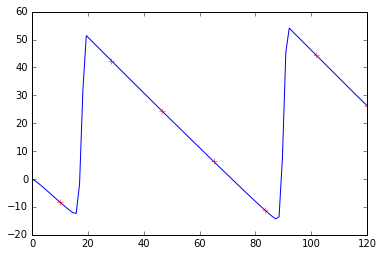

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Example1
from timevarying_covar import time_discretisation_handler

odeModel = Example1.nonlinearFrictionODE()

dim = 2
initCond = [0., 0.5, 0.8]
tt = np.linspace(0., 120, 100)

sol = odeModel.solve(initCond, tt)


evalt = np.linspace(10,120, 7)
tk = np.linspace(0., 120., 25)

model_t = np.sort(np.concatenate((evalt, tk)))

sol2 = odeModel.solve(initCond, model_t)

# Indices of the evaluated points in the augmented time vector
eval_t_ind = [sum(tk < t) + sum(evalt < t) for t in evalt]
tk_ind = [i for i in range(model_t.size) if not i in eval_t_ind]


plt.plot(tt, sol[:,0], '-')
plt.plot(evalt, sol2[eval_t_ind,0], 'r+')
plt.show()

In [2]:
tta, ttm, ttb, Att = time_discretisation_handler(evalt, tk, lambda x: None, 2)

tt_ode_solve = np.sort(np.concatenate(([0.], ttm)))
tk_ind = [i for i in range(tt_ode_solve.size - 1) if not i in eval_t_ind]

sortInds = np.argsort(ttm)
evalt_inds = [np.where(sortInds == i)[0][0] for i in range(evalt.size) ]
tk_inds = [i for i in range(ttm.size) if not i in evalt_inds]

tt_ode = np.concatenate(([0.], ttm[sortInds]))

sol = odeModel.solve(initCond, tt_ode)
At_ = [odeModel.dXdt_Jac(x) for x in sol[1:,:2] ]
Att = [At_[i] for i in evalt_inds] +  [At_[i] for i in tk_inds]

###
# We are now ready to pass (tta, ttm, ttb), Att to the return the covariance function
#
#

In [3]:
# Steps involved for returning the covariance at a particular 

# define the ksqexp kernel, with additional pre and post multiplication by a vector b(t)
#
# slot those features into makeCov and makeCovYf

# define points on which the gp should be conditioned
fcond_t = np.linspace(0., 120, 6)

# Calculate Cov{Y(evalt),Y(evalt)} | Cov{Y(evalt),f(fcond_t)}
#                 

### Set up the kernel
from covariance_util import ksqexp
from timevarying_covar import makeCovYf, makeCov_sym

cScales = np.array([0., 1.])
lScales = np.array([1., 20.])

def kfunc(s, t):
    return ksqexp(s, t, cScales, lScales, S=None, returnType='matrix')

S = np.array(None)

k = kfunc(0.3, fcond_t).reshape(fcond_t.size, 4)

Cff = kfunc( fcond_t, fcond_t)
Cyf = makeCovYf( (tta, ttm, ttb), fcond_t, Att, kfunc, 2)
Cyy = makeCov_sym( (tta, ttm, ttb), Att, kfunc, 2)

ff_rows = np.array([[1, 1],
                 [3, 3]], dtype=np.intp)
ff_cols = ff_rows.T


In [4]:
# Turns out to be easier to pass through a conditioned kernel, because of the singular
# dimensions
dim = 2
ff_rows = np.column_stack(( np.array([i*dim + 1 for i in range(fcond_t.size)])[:,None] for j in range(fcond_t.size)))

ff_cols = ff_rows.T

Cff_ = Cff[ff_rows, ff_cols]

### assumption: will only ever be passed as an argument to makeCov_sym
def kfuncCond(s, tcond):
    ss_ = np.concatenate((s, tcond))
    
    Sigma = ksqexp(ss_, ss_, cScales, lScales, S=None, returnType='ind')[1]
    S11 = Sigma[:s.size,:s.size]
    S12 = Sigma[:s.size,s.size:]
    S22 = Sigma[s.size:, s.size:]
    
    L = np.linalg.cholesky(S22)
    
    covCond = S11 - np.dot(S12, np.linalg.solve(L.T, np.linalg.solve(L, S12.T)))
    return covCond



In [5]:
import scipy.linalg
##
# Handles the construction of the kernel in the presence of conditioning
# and possibly masked components
def Kcond(tt, tcond, cScales, lScales, dim):
    result = np.zeros((tt.size*dim, tt.size*dim))
    tt_ = np.concatenate((tt, tcond))
    Sigma = ksqexp(tt_, tt_, cScales, lScales, S=None, returnType='ind')
    
    for k in range(dim):
        if cScales[k] != 0.:
            Sigma_k = Sigma[k]             # The kth component of the GP
            S11 = Sigma_k[:tt.size,:tt.size]
            S12 = Sigma_k[:tt.size,tt.size:]
            S22 = Sigma_k[tt.size:, tt.size:]
            L = np.linalg.cholesky(S22)
    
            covCond = S11 - np.dot(S12, np.linalg.solve(L.T, np.linalg.solve(L, S12.T)))
        
            # get the indices to put the conditioned covariance back into result
            rows = np.column_stack(( np.array([i*dim + k for i in range(tt.size)])[:,None] for j in range(tt.size)))
            result[rows, rows.T] = covCond
            
    return result

Cc = Kcond(evalt, fcond_t, cScales, lScales, dim)

# Test it
#k = 1
#rows = np.column_stack(( np.array([i*dim + k for i in range(evalt.size)])[:,None] for j in range(evalt.size)))
#print np.linalg.eig(Cc)[0]
#print np.linalg.eig(Cc[rows, rows.T])[0]

###
# Returns the covariance for the nonlinear model deltaY
# conditioned on a small Gaussian process
def cond_wrapped_makeCov_sym(S, A, dim, tcond, cScales, lScales):
    sa, sm, sb = S
    ss_full = np.concatenate((sa, sm, sb))
    K = Kcond(ss_full, tcond, cScales, lScales, dim)
    
    
    N = S[0].size
    
    K11 = K[:N*dim, :N*dim]
    K12 = K[:N*dim, N*dim:2*N*dim]
    K13 = K[:N*dim, 2*N*dim:3*N*dim]
    
    K21 = K12.T
    K22 = K[N*dim:2*N*dim, N*dim:2*N*dim]
    K23 = K[N*dim:2*N*dim, 2*N*dim:3*N*dim]
    
    K31 = K13.T
    K32 = K23.T
    K33 = K[2*N*dim:, 2*N*dim: ]

    result = np.zeros((N*dim, N*dim))

    for i in range(N):

        eAi1 = scipy.linalg.expm(A[i]*(sb[i]-sa[i]))
        eAi2 = scipy.linalg.expm(A[i]*(sb[i]-sm[i]))

        for j in range(i+1):

            eBj1 = scipy.linalg.expm(A[j].T*(sb[j]-sa[j]))
            eBj2 = scipy.linalg.expm(A[j].T*(sb[j]-sm[j]))

            I11 = np.dot(eAi1, np.dot(K11[i*dim:(i+1)*dim, j*dim:(j+1)*dim], eBj1))
            I12 = 4*np.dot(eAi1, np.dot(K12[i*dim:(i+1)*dim, j*dim:(j+1)*dim], eBj2))
            I13 = np.dot(eAi1, K13[i*dim:(i+1)*dim, j*dim:(j+1)*dim])

            I21 = np.dot(eAi2, np.dot(K21[i*dim:(i+1)*dim, j*dim:(j+1)*dim], eBj1))
            I22 = 4*np.dot(eAi2, np.dot(K22[i*dim:(i+1)*dim, j*dim:(j+1)*dim], eBj2))
            I23 = np.dot(eAi2, K23[i*dim:(i+1)*dim, j*dim:(j+1)*dim])

            I31 = np.dot(K31[i*dim:(i+1)*dim, j*dim:(j+1)*dim], eBj1)
            I32 = 4*np.dot(K32[i*dim:(i+1)*dim, j*dim:(j+1)*dim], eBj2)
            I33 = K33[i*dim:(i+1)*dim, j*dim:(j+1)*dim]

            expr1 = I11 + I12 + I13
            expr2 = I21 + I22 + I23
            expr3 = I31 + I32 + I33

            ival = (sb[i]-sa[i])*(sb[j]-sa[j])*(expr1 + 4*expr2 + expr3)/36.

            result[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = ival
            result[j*dim:(j+1)*dim, i*dim:(i+1)*dim] = ival.T

    return result
    
    
SigmaDyDy = cond_wrapped_makeCov_sym( (tta, ttm, ttb), Att, 2, fcond_t, cScales, lScales)
print np.max(abs(SigmaDyDy - SigmaDyDy.T))

print evalt.size + sum(tk < evalt[-1]) - 1
print tta.size
from core import MaketvcTransformationMatrix
#T = MaketvcTransformationMatrix(evalt, tk, At, 2)

6.93889390391e-18
30
30


In [6]:
def At(t):
    return np.array([[ t, 0.3],
                     [0., -t**2]])

tt = np.array([0.2, 0.5, 0.6, 0.8])
tk = np.array([0., 0.33, 0.66, 1.0])

Ati = [At(t) for t in tt]
Atk = [At(t) for t in tk]

i = 2
dim = 2
NG = sum(tk < tt[-1]) - 1
Id = np.diag(np.ones(dim))

Trow = np.column_stack(( Id for nt in range(NG) ))

# relevant collection of tks
tauSet = tk[tk < tt[i]]
tauSet = tauSet[1:]

import scipy.linalg
from scipy.linalg import expm

if len(tauSet > 0):
    for nt in range(tauSet.size - 1):
        eA = scipy.linalg.expm(Atk[nt+1]*(tauSet[nt+1]-tauSet[nt]))
        for k in range(nt+1):
            Trow[:,k*dim:(k+1)*dim] = np.dot( eA, Trow[:,k*dim:(k+1)*dim] )

    eAi = scipy.linalg.expm(Ati[i]*(tt[i] - tauSet[-1]))
    for k in range(len(tauSet)):
        Trow[:,k*dim:(k+1)*dim] = np.dot( eAi, Trow[:,k*dim:(k+1)*dim] )

print Trow
print "========================="


[[ 1.17586024  0.08390179  1.          0.        ]
 [ 0.          0.90737451  0.          1.        ]]


In [7]:
def makeT( Ati, Atk, tt, tk, dim):
    NG = sum(tk < tt[-1]) - 1
    Id = np.diag(np.ones(dim))
    
    result = np.zeros((tt.size*dim, NG*dim))
    
    for i in range(tt.size):
        result[i*dim:(i+1)*dim, :] = np.column_stack((Id for nt in range(NG)))
        
        tauSet = tk[tk < tt[i]]
        tauSet = tauSet[1:]
        
        if len(tauSet > 0):
            for nt in range(tauSet.size - 1):
                eA = scipy.linalg.expm(Atk[nt+1]*(tauSet[nt+1]-tauSet[nt]))
                for k in range(nt+1):
                    result[i*dim:(i+1)*dim, k*dim:(k+1)*dim] = np.dot(eA, result[i*dim:(i+1)*dim, k*dim:(k+1)*dim] )
            
            eAi = scipy.linalg.expm(Ati[i]*(tt[i] - tauSet[-1]))
            for k in range(len(tauSet)):
                result[i*dim:(i+1)*dim, k*dim:(k+1)*dim] = np.dot( eAi, result[i*dim:(i+1)*dim, k*dim:(k+1)*dim] )
    
    return result

print makeT( Ati, Atk, tt, tk, 2)


[[ 1.          0.          1.          0.        ]
 [ 0.          1.          0.          1.        ]
 [ 1.08871707  0.05213064  1.          0.        ]
 [ 0.          0.95839047  0.          1.        ]
 [ 1.17586024  0.08390179  1.          0.        ]
 [ 0.          0.90737451  0.          1.        ]
 [ 1.2471987   0.15599069  1.11851286  0.04254501]
 [ 0.          0.88202313  0.          0.91429683]]


In [10]:
from get_cov_result import result

R = result(evalt, tk, 2, 
           fcond_t, cScales, lScales,
           odeModel, initCond, 0.)

print np.linalg.eig(R)[0]

(14, 6)
(20, 20)
(14, 20)
[  1.12989666e+01   1.08098510e+00   1.86936032e-01   4.10489004e-02
   4.49185855e-03   1.00762639e-04   3.99081505e-06   8.43791389e-12
   4.36718563e-14   9.56966390e-16   5.48935515e-19  -5.20019066e-21
   5.80940566e-24   6.61654431e-27]


In [27]:
tta, ttm, ttb, Att = time_discretisation_handler(tt, tk, lambda x: None, dim)

print tt
print tk
print tta
print ttb

[ 0.2  0.5  0.6  0.8]
[ 0.    0.33  0.66  1.  ]
[ 0.    0.33  0.33  0.66  0.    0.33]
[ 0.2   0.5   0.6   0.8   0.33  0.66]


In [31]:
# 
tmax = tt[-1]

tknots = tk[tk < tmax]
print tknots



#tta = np.concatenate(( tknots, tknots[:-1]))
ttb = np.concatenate(( tt, tknots[1:]))
print tta
print ttb
fcond_t

[ 0.]
[   5.   25.   45.   60.   80.  100.  115.    0.    5.   10.   15.   20.
   25.   30.   35.   40.   45.   50.   55.   60.   65.   70.   75.   80.
   85.   90.   95.  100.  105.  110.]
[ 0.2  0.5  0.6  0.8]


array([   0.,   24.,   48.,   72.,   96.,  120.])

(200, 26)
(226, 226)
(200, 226)


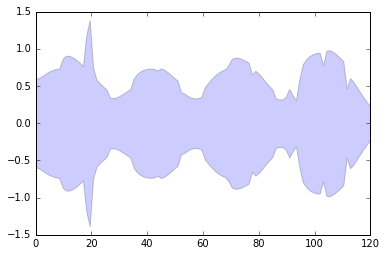

In [50]:
evalt = np.linspace(0.001,120, 100)
tk = np.linspace(0., 120., 15)

sol = odeModel.solve(initCond, np.concatenate(([0.], evalt)))[1:,]

fcond_t = np.linspace(0., 120, 5)

R = result(evalt, tk, 2, 
           fcond_t, cScales, lScales,
           odeModel, initCond, 0.)

compInd = 0

var = np.diag(R).reshape(evalt.size, 2)
sd = np.sqrt(var)[:,compInd]

fig = plt.figure()
ax = fig.add_subplot(111)

#ax.fill_between(evalt, sol[:,compInd] - 2*sd, sol[:,compInd] + 2*sd, alpha=0.2)
#ax.set_xlim((20, 80))
ax.fill_between(evalt,  - 2*sd, + 2*sd, alpha=0.2)
#ax.plot(evalt, sol[:,compInd], 'k-.')
plt.show()

In [59]:
eigMax = 0.
for x in sol[:,]:
    A = odeModel.dXdt_Jac(x)
    eig = np.linalg.eig(A)[0]
    Re_eig = np.real(eig)
    print min(Re_eig), max(Re_eig)
    if max(Re_eig) > eigMax:
        eigMax = max(Re_eig)

print eigMax

-1.5963011847 -0.626448197611
-2.15669373262 -0.463672697183
-2.40210991827 -0.41630068316
-2.5201928607 -0.396795029299
-2.57987498995 -0.387615680565
-2.60836656479 -0.383381696997
-2.61691121105 -0.382129892591
-2.60972209791 -0.383182562159
-2.58676034941 -0.386583937019
-2.543515262 -0.393156673734
-2.46690374325 -0.405366444774
-2.31768528605 -0.431464964643
-1.9206410932 -0.52065948372
-0.592573054826 -0.592573054826
-0.073566521001 -0.073566521001
-0.0537072863322 -0.0537072863322
-2.99984763917 -0.333350263174
-2.99978127158 -0.333357638263
-2.99968625488 -0.333368197548
-2.99955044403 -0.333383291483
-2.99935704775 -0.333404787786
-2.99908180356 -0.333435386395
-2.99869290137 -0.33347862982
-2.99814649661 -0.333539405473
-2.99738536321 -0.33362410195
-2.99633716377 -0.333740812647
-2.99491498906 -0.333899293854
-2.99302229027 -0.334110441893
-2.99056372083 -0.334385117105
-2.9874635656 -0.334732115737
-2.98368942726 -0.335155526196
-2.9792750386 -0.335652125783
-2.97433088495